# Table of Contents

* [Introduction](#Introduction)
* [Data preprocessing](#data-prep)
    * [Outliers treatment](#outliers)
    * [Scaling](#scaling)
    * [Balancing](#balancing)

# Introduction

Vous êtes développeur dans une entreprise qui travaille dans le domaine de la FinTech. Votre client est une société d'investissement qui souhaite détecter les faillites d'entreprises, ce qui leur permet de mieux comprendre et gérer les risques.


Votre objectif est de créer un modèle de machine learning pour détecter la probabilité de faire faillite en utilisant les decision trees et les méthodes ensemblistes (bagging, boosting and stacking).


Pour cela, vous disposez d'un dataset avec 95 features (X1-X95) et un target. Les features représentent des indicateurs définis par les réglementations commerciaux de la Bourse. Votre target est appelé "Bankrupt ?", qui a la valeur 0 si l'entreprise n'a pas fait faillite, et la valeur 1 si l'entreprise a fait faillite.


# Import libraries

In [ ]:
!pip install imblearn

In [248]:
import os

# Visualisation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Algorithms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

# Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from imblearn import FunctionSampler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn import set_config; set_config(display='diagram')

# Metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix

from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

from sklearn.model_selection import learning_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.inspection import permutation_importance

# Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

# Deploy
import pickle

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Fetching

In [3]:
file_path = os.path.join("../data/data_cleaned.csv")  # Filepath of CSV file

In [4]:
df = pd.read_csv(file_path)
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490


# Feature Selections

In [5]:
X = df.iloc[:, 1:]
y = df['Bankrupt?']

# ML Modeling

## Data Splitting

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y) # split data into train/test sets

## Preprocessing pipelines

In [ ]:
# checking features which do or do not have a normal distribution
def check_not_normal(X):
    data = []
    for i in X.columns:
        if X[i].skew() < -0.9 or X[i].skew() > 0.9:
            data.append(i)

    return data

def check_normal(X):
    data = []
    for i in X.columns:
        if X[i].skew() > -0.9 and X[i].skew() < 0.9:
            data.append(i)

    return data

ftr_to_scale = check_not_normal(X)
ftr_to_norm = check_normal(X)

In [ ]:
scaling_itr = ColumnTransformer([
    ('scaling', StandardScaler(), ftr_to_scale)
], remainder='passthrough')

In [ ]:
normalize_itr = ColumnTransformer([
    ('normal scaling', MinMaxScaler(), ftr_to_norm),
], remainder='passthrough')

In [ ]:
scaling_nrm_itr = ColumnTransformer([
    ('normal scaling', MinMaxScaler(), ftr_to_norm),
    ('standard scaling', StandardScaler(), ftr_to_scale)
], remainder='passthrough')

In [ ]:
robust_sc_itr = Pipeline([
    ('robust scaling', RobustScaler())
])

## Performance metrics

In [ ]:
# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
def learning_curves(model, features, target):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model,
                                                            X = features,
                                                            y = target,
                                                            train_sizes = [5,10,50,100,200,500,1000,2000,3000,5000],
                                                            cv = 5,
                                                            scoring='recall',
                                                            shuffle = True,
                                                            random_state=3)

    # Take the mean of cross-validated train scores and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Plot the learning curves!
    plt.plot(train_sizes, train_scores_mean, label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, label = 'Test score')
    plt.ylabel('Recall', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves - log model', fontsize = 18, y = 1.03)
    plt.legend()
    plt.show()


In [ ]:
# ROC Curve
def roc_auc(model, X_tst, y_tst):
    plot_roc_curve(model_base, X_tst, y_tst)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.show()


In [ ]:
# Confusion Matrix
def plot_confusion_matrix(y_tst, y_hat):
    rec = round(recall_score(y_tst, y_hat), 2)
    cm = confusion_matrix(y_tst, y_hat)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Recall Score: {0}'.format(rec), size=20)
    plt.show()


## Models

### Baseline model

In [ ]:
model_base = DecisionTreeClassifier(random_state=123) # define model
model_base.fit(X_train, y_train) # fit model

y_pred_base = model_base.predict(X_test) # predicted values

In [ ]:
# Classification report
print(classification_report(y_test, y_pred_base))

In [ ]:
learning_curves(model_base, X, y)

In [ ]:
roc_auc(model_base, X_test, y_test)

In [ ]:
plot_confusion_matrix(y_test, y_pred_base)

### Decision Tree

##### DT w/ standard scaling

In [13]:
scaling_dt = Pipeline([
    ('scaling', scaling_itr),
    ('decision tree', DecisionTreeClassifier())
])

# Train pipeline
scaling_dt_trnd = scaling_dt.fit(X_train,y_train)

y_pred = scaling_dt_trnd.predict(X_test) # predicted values

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1320
           1       0.20      0.23      0.22        44

    accuracy                           0.95      1364
   macro avg       0.59      0.60      0.59      1364
weighted avg       0.95      0.95      0.95      1364



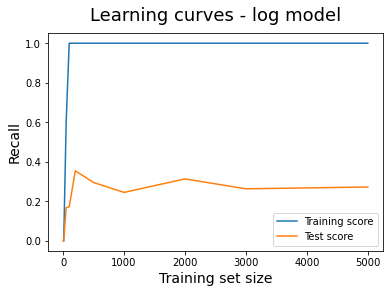

In [193]:
learning_curves(scaling_dt_trnd, X, y)

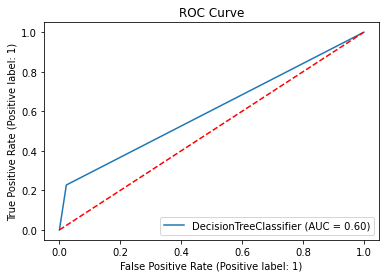

In [33]:
roc_auc(scaling_dt_trnd, X_test, y_test)

##### DT w/ normal scaling

In [199]:
nrm_dt = Pipeline([
    ('normal scaling', normalize_itr),
    ('decision tree', DecisionTreeClassifier()),
])

In [200]:
# Train pipeline
nrm_dt_trnd = nrm_dt.fit(X_train, y_train)

# predicted values
y_pred = nrm_dt_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1320
           1       0.23      0.20      0.22        44

    accuracy                           0.95      1364
   macro avg       0.60      0.59      0.60      1364
weighted avg       0.95      0.95      0.95      1364



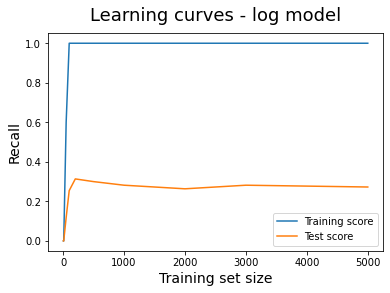

In [201]:
learning_curves(nrm_dt_trnd, X, y)

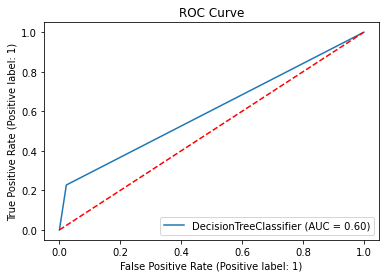

In [202]:
roc_auc(nrm_dt_trnd, X_test, y_test)

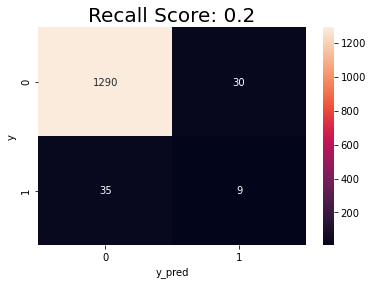

In [203]:
plot_confusion_matrix(y_test, y_pred)

##### DT w/ standard | normalize scaling

In [28]:
scaling_nrm_dt = Pipeline([
    ('normal/standard scaling', scaling_nrm_itr),
    ('decision tree', DecisionTreeClassifier()),
])

In [29]:
# Train pipeline
scaling_nrm_dt_trnd = scaling_nrm_dt.fit(X_train, y_train)

# predicted values
y_pred = scaling_dt_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1320
           1       0.20      0.23      0.22        44

    accuracy                           0.95      1364
   macro avg       0.59      0.60      0.59      1364
weighted avg       0.95      0.95      0.95      1364



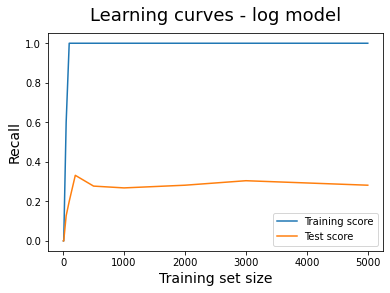

In [194]:
learning_curves(scaling_nrm_dt_trnd, X, y)

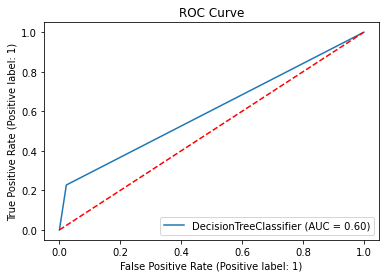

In [204]:
roc_auc(scaling_nrm_dt_trnd, X_test, y_test)

##### DT w/ normal | standard and robust scaling

In [122]:
robust_dt = Pipeline([
    ('scaling/normalize', scaling_nrm_itr),
    ('robust scaling', RobustScaler()),
    ('decision tree', DecisionTreeClassifier())
])

In [123]:
# Train pipeline
robust_dt_trnd = robust_dt.fit(X_train, y_train)

# predicted values
y_pred = robust_dt_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1320
           1       0.24      0.25      0.25        44

    accuracy                           0.95      1364
   macro avg       0.61      0.61      0.61      1364
weighted avg       0.95      0.95      0.95      1364



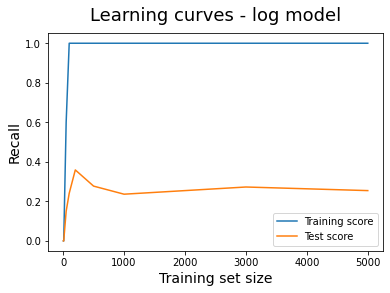

In [195]:
learning_curves(robust_dt_trnd, X, y)

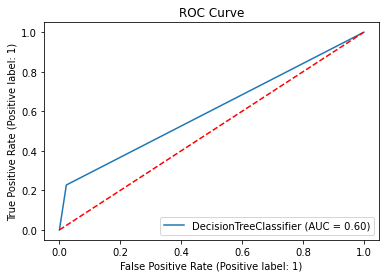

In [38]:
roc_auc(robust_dt_trnd, X_test, y_test)

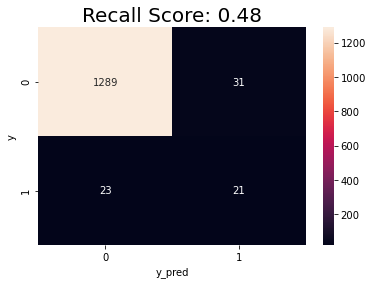

In [196]:
plot_confusion_matrix(y_test, y_pred)

##### DT w/ oversampling balancing (SMOTE)

In [162]:
balancing_dt = imbpipeline([
    ('scaling/normalize', scaling_nrm_itr),
    ('robust scaling', RobustScaler()),
    ('smote', SMOTE()),
    ('decision tree', DecisionTreeClassifier())
])

In [154]:
# Train pipeline
balancing_dt_trnd = balancing_dt.fit(X_train, y_train)

# predicted values
y_pred = balancing_dt_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1320
           1       0.22      0.50      0.30        44

    accuracy                           0.93      1364
   macro avg       0.60      0.72      0.63      1364
weighted avg       0.96      0.93      0.94      1364



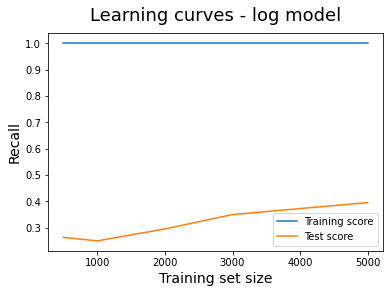

In [197]:
learning_curves(balancing_dt_trnd, X, y)

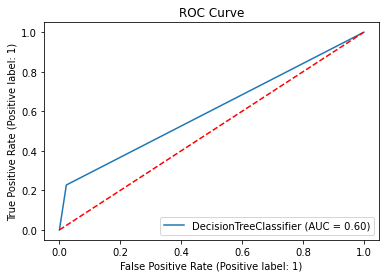

In [143]:
roc_auc(balancing_dt_trnd, X_test, y_test)

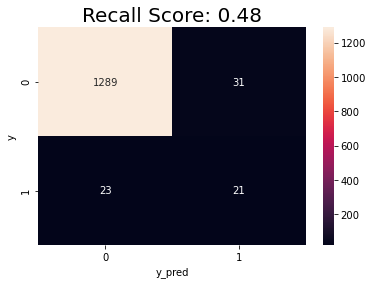

In [198]:
plot_confusion_matrix(y_test, y_pred)

------------------------

### Random Forest Classifier

#### RF w/out robust scaling

In [209]:
rfc_pipe = imbpipeline([
    ('scaling/normalize', scaling_nrm_itr),
    ('smote', SMOTE()),
    ('random forest', RandomForestClassifier())
])

In [210]:
# Train pipeline
rfc_trnd = rfc_pipe.fit(X_train, y_train)

# predicted values
y_pred = rfc_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.43      0.48      0.45        44

    accuracy                           0.96      1364
   macro avg       0.71      0.73      0.72      1364
weighted avg       0.96      0.96      0.96      1364



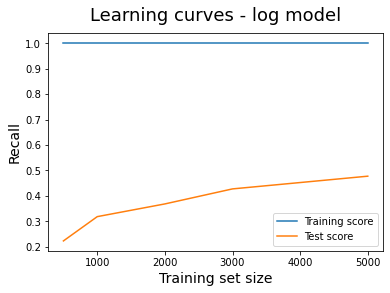

In [207]:
learning_curves(rfc_trnd, X, y)

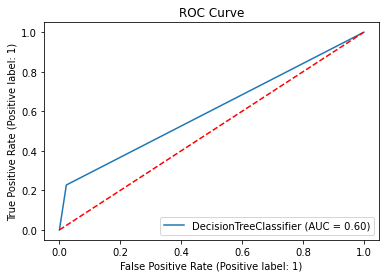

In [171]:
roc_auc(rfc_trnd, X_test, y_test)

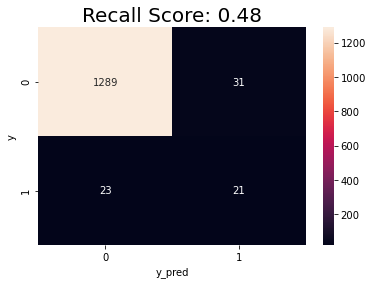

In [190]:
plot_confusion_matrix(y_test, y_pred)

#### RF w/ robust scaling

In [208]:
rfc_rb_pipe = imbpipeline([
    ('scaling/normalize', scaling_nrm_itr),
    ('robust scaling', RobustScaler()),
    ('smote', SMOTE()),
    ('random forest', RandomForestClassifier())
])

In [212]:
# Train pipeline
rfc_rb_trnd = rfc_rb_pipe.fit(X_train, y_train)

# predicted values
y_pred = rfc_rb_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.42      0.57      0.48        44

    accuracy                           0.96      1364
   macro avg       0.70      0.77      0.73      1364
weighted avg       0.97      0.96      0.96      1364



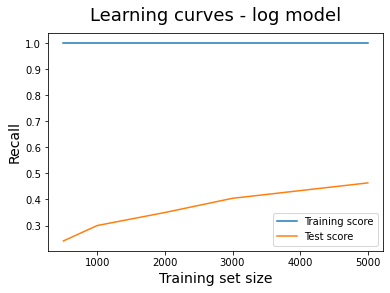

In [213]:
learning_curves(rfc_rb_trnd, X, y)

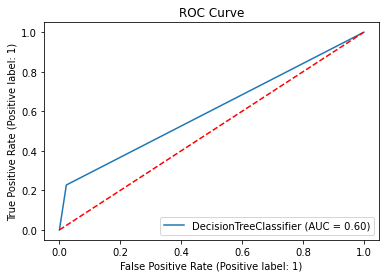

In [214]:
roc_auc(rfc_rb_trnd, X_test, y_test)

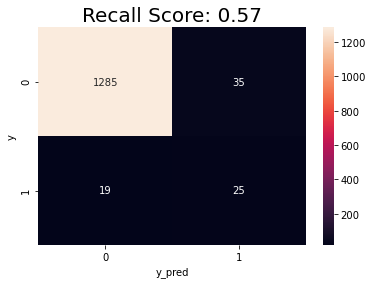

In [215]:
plot_confusion_matrix(y_test, y_pred)

### Bagging Classifier

#### Bagging w/ decision tree

##### W/out robust scaling

In [229]:
bagging_dt = imbpipeline([
    ('scaling/normal', scaling_nrm_itr),
    ('smote', SMOTE()),
    ('bagging', BaggingClassifier(base_estimator=DecisionTreeClassifier())),
])

In [230]:
# Train pipeline
bagging_dt_trnd = bagging_dt.fit(X_train, y_train)

# predicted values
y_pred = bagging_dt_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1320
           1       0.29      0.39      0.33        44

    accuracy                           0.95      1364
   macro avg       0.64      0.68      0.65      1364
weighted avg       0.96      0.95      0.95      1364



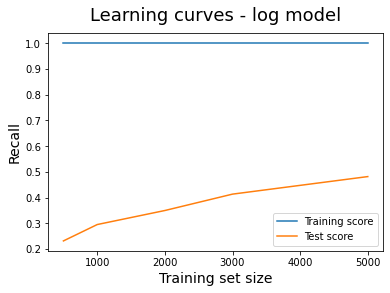

In [220]:
learning_curves(bagging_dt_trnd, X, y)

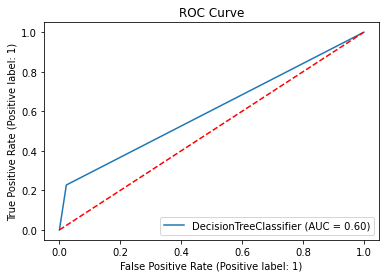

In [221]:
roc_auc(bagging_dt_trnd, X_test, y_test)

##### W/ robust scaling

In [231]:
bagging_rb_dt = imbpipeline([
    ('scaling/normal', scaling_nrm_itr),
    ('robust scaling', RobustScaler()),
    ('smote', SMOTE()),
    ('bagging', BaggingClassifier(base_estimator=DecisionTreeClassifier())),
])

In [232]:
# Train pipeline
bagging_rb_dt_trnd = bagging_rb_dt.fit(X_train, y_train)

# predicted values
y_pred = bagging_rb_dt_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.38      0.43      0.40        44

    accuracy                           0.96      1364
   macro avg       0.68      0.70      0.69      1364
weighted avg       0.96      0.96      0.96      1364



#### Bagging w/ random forest

##### W/out robust scaling

In [233]:
bagging_rf = imbpipeline([
    ('scaling/normal', scaling_nrm_itr),
    ('smote', SMOTE()),
    ('bagging', BaggingClassifier(base_estimator=RandomForestClassifier())),
])

In [234]:
# Train pipeline
bagging_rf_trnd = bagging_rf.fit(X_train, y_train)

# predicted values
y_pred = bagging_rf_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.36      0.57      0.44        44

    accuracy                           0.95      1364
   macro avg       0.67      0.77      0.71      1364
weighted avg       0.97      0.95      0.96      1364



##### W/ robust scaling

In [236]:
bagging_rb_rf = imbpipeline([
    ('scaling/normal', scaling_nrm_itr),
    ('robust scaling', RobustScaler()),
    ('smote', SMOTE()),
    ('bagging', BaggingClassifier(base_estimator=RandomForestClassifier())),
])

In [237]:
# Train pipeline
bagging_rb_rf_trnd = bagging_rb_rf.fit(X_train, y_train)

# predicted values
y_pred = bagging_rb_rf_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1320
           1       0.35      0.66      0.46        44

    accuracy                           0.95      1364
   macro avg       0.67      0.81      0.72      1364
weighted avg       0.97      0.95      0.96      1364



### Boosting

#### AdaBoost classifier

##### Adaboost w/ random forest

###### W/out robust scaling

In [241]:
adaboost_rf = imbpipeline([
    ('scaling/normal', scaling_nrm_itr),
    ('smote', SMOTE()),
    ('adaboost', AdaBoostClassifier(base_estimator=RandomForestClassifier())),
])

In [245]:
# Train pipeline
adaboost_rf_trnd = adaboost_rf.fit(X_train, y_train)

# predicted values
y_pred = adaboost_rf_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.39      0.45      0.42        44

    accuracy                           0.96      1364
   macro avg       0.69      0.72      0.70      1364
weighted avg       0.96      0.96      0.96      1364



###### W/ robust scaling

In [243]:
adaboost_rb_rf = imbpipeline([
    ('scaling/normal', scaling_nrm_itr),
    ('robust scaling', RobustScaler()),
    ('smote', SMOTE()),
    ('adaboost', AdaBoostClassifier(base_estimator=RandomForestClassifier())),
])

In [246]:
# Train pipeline
adaboost_rb_rf_trnd = adaboost_rb_rf.fit(X_train, y_train)

# predicted values
y_pred = adaboost_rb_rf_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1320
           1       0.37      0.50      0.42        44

    accuracy                           0.96      1364
   macro avg       0.67      0.74      0.70      1364
weighted avg       0.96      0.96      0.96      1364



#### XGBoost classifier

##### XGBoost w/ random forest

###### W/out robust scaling

In [ ]:
XGBoost_rf = imbpipeline([
    ('scaling/normal', scaling_nrm_itr),
    ('smote', SMOTE()),
    ('adaboost', XGBClassifier()),
])

In [ ]:
# Train pipeline
XGBoost_rf_trnd = XGBoost_rf.fit(X_train, y_train)

# predicted values
y_pred = XGBoost_rf_trnd.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))